# RL  Assignment: 4

## Exercise 1: Monte Carlo – Blackjack Policy Evaluation
#### By: Murad Tadesse
##### GSR/9304/16
###### February 2025

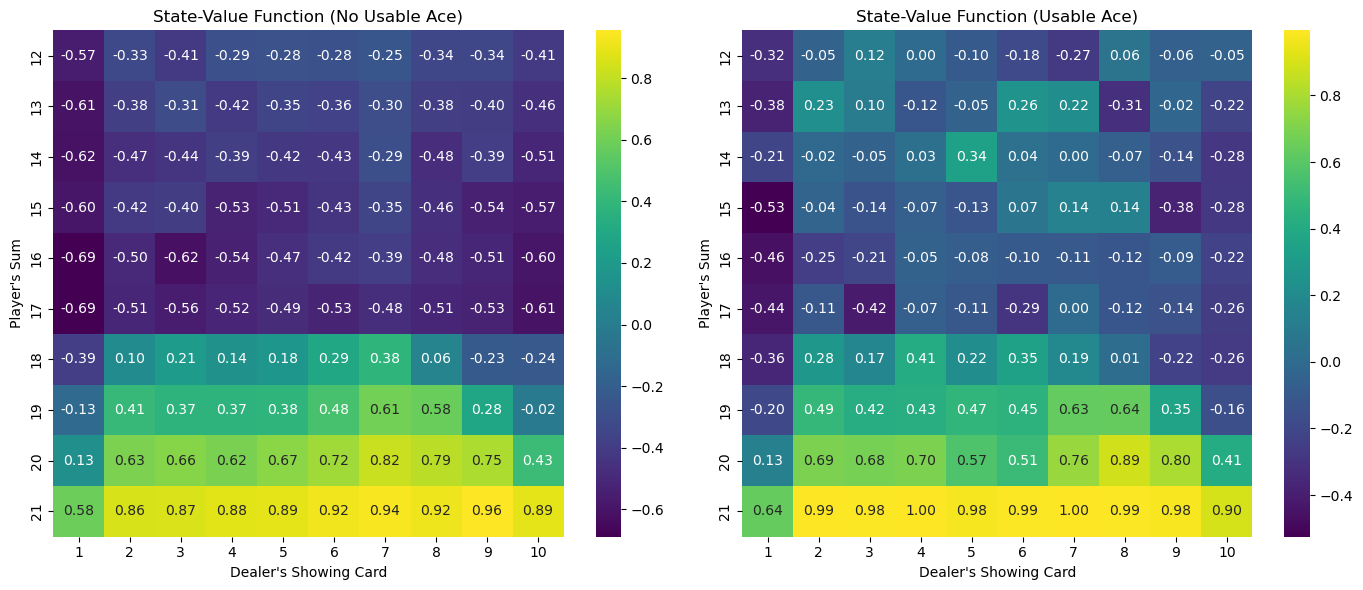

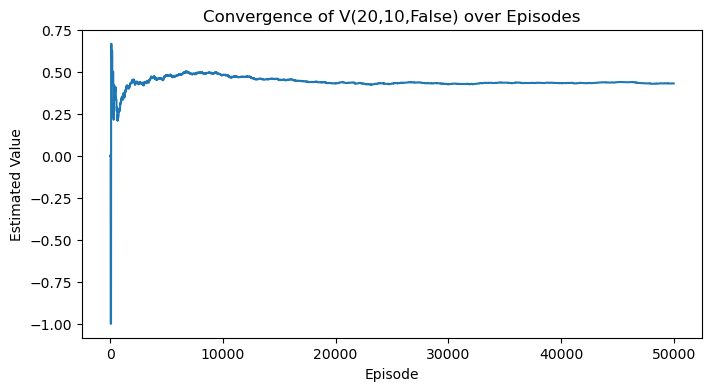

Monte Carlo Policy Evaluation (Blackjack)
-----------------------------------------------------
• A fixed policy ('stick if player sum >= 18, otherwise hit') is evaluated using first-visit MC sampling.
• The player's sum is converted to an integer if needed (if the returned value is a tuple).
• Two heatmaps (usable ace vs. no usable ace) show the state-value estimates for different player sums and dealer cards.
• A convergence plot of V(20,10,False) indicates stabilization of the estimate as more episodes are simulated.


In [7]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # For nicer heatmaps

# ----- Set Up Environment and Policy -----
env = gym.make('Blackjack-v1')

def fixed_policy(state):
    """
    Fixed policy for Blackjack evaluation.
    Expects state as a tuple.
    If len(state)==2, we assume no usable ace.
    Also, if the player's sum is a tuple, extract its first element.
    Policy: Stick (action 0) if player's sum >= 18, else Hit (action 1).
    """
    # Depending on the returned format, unpack state:
    if len(state) == 2:
        player_sum, dealer_card = state
        usable_ace = False
    else:
        player_sum, dealer_card, usable_ace = state

    # If player_sum is not a number (e.g., a tuple), get its first element.
    if isinstance(player_sum, tuple):
        player_sum = player_sum[0]

    return 0 if player_sum >= 18 else 1

# ----- Monte Carlo Evaluation Parameters -----
n_episodes = 50000  # Total episodes to simulate
returns_sum = {}    # Sum of observed returns per state
returns_count = {}  # Count per state (for first visit)
V = {}              # Estimated state-value function

# For a convergence plot, track a single state (e.g., (20, 10, False))
sample_state = (20, 10, False)
convergence = []  # Evolving estimate of V(sample_state)

# ----- Monte Carlo First-Visit Policy Evaluation -----
for ep in range(1, n_episodes + 1):
    episode = []      # List to store states visited in this episode

    # Handle possible new API from Gym's reset (state, info) format.
    result = env.reset()
    if isinstance(result, tuple) and len(result) == 2:
        state, _ = result
    else:
        state = result

    done = False
    while not done:
        # Use the fixed policy to choose an action.
        action = fixed_policy(state)
        episode.append(state)
        
        # Call step() and check if using new API (5 items) or old (4 items)
        result = env.step(action)
        if len(result) == 5:
            # New Gym API: (obs, reward, terminated, truncated, info)
            state, reward, terminated, truncated, _ = result
            done = terminated or truncated
        else:
            # Old API: (obs, reward, done, info)
            state, reward, done, _ = result

    # In Blackjack, reward only comes at the end of the episode.
    G = reward

    # First-visit MC: update returns only for the first time a state is visited.
    visited_states = set()
    for s in episode:
        if s not in visited_states:
            visited_states.add(s)
            if s not in returns_sum:
                returns_sum[s] = 0.0
                returns_count[s] = 0
            returns_sum[s] += G
            returns_count[s] += 1
            V[s] = returns_sum[s] / returns_count[s]
    
    # Record the evolving estimate for our sample_state
    convergence.append(V.get(sample_state, 0))

# ----- Organize Data for Heatmaps -----
# Focus on states with player sums between 12 and 21 and dealer showing 1 to 10.
player_range = np.arange(12, 22)
dealer_range = np.arange(1, 11)

def create_heatmap_data(usable_ace_flag):
    # Create a 2D grid with rows = player's sum and columns = dealer's card.
    values = np.zeros((len(player_range), len(dealer_range)))
    for i, player in enumerate(player_range):
        for j, dealer in enumerate(dealer_range):
            state = (player, dealer, usable_ace_flag)
            values[i, j] = V.get(state, 0)
    return values

heatmap_no_ace   = create_heatmap_data(False)
heatmap_usable_ace = create_heatmap_data(True)

# ----- Plot the Heatmaps -----
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.heatmap(heatmap_no_ace, xticklabels=dealer_range, yticklabels=player_range,
            annot=True, fmt=".2f", cmap="viridis")
plt.title("State-Value Function (No Usable Ace)")
plt.xlabel("Dealer's Showing Card")
plt.ylabel("Player's Sum")

plt.subplot(1, 2, 2)
sns.heatmap(heatmap_usable_ace, xticklabels=dealer_range, yticklabels=player_range,
            annot=True, fmt=".2f", cmap="viridis")
plt.title("State-Value Function (Usable Ace)")
plt.xlabel("Dealer's Showing Card")
plt.ylabel("Player's Sum")

plt.tight_layout()
plt.show()

# ----- Plot Convergence of a Sample State Value -----
plt.figure(figsize=(8, 4))
plt.plot(np.arange(n_episodes), convergence)
plt.title("Convergence of V(20,10,False) over Episodes")
plt.xlabel("Episode")
plt.ylabel("Estimated Value")
plt.show()

# ----- Experiment Analysis -----
print("Monte Carlo Policy Evaluation (Blackjack)")
print("-----------------------------------------------------")
print("• A fixed policy ('stick if player sum >= 18, otherwise hit') is evaluated using first-visit MC sampling.")
print("• The player's sum is converted to an integer if needed (if the returned value is a tuple).")
print("• Two heatmaps (usable ace vs. no usable ace) show the state-value estimates for different player sums and dealer cards.")
print("• A convergence plot of V(20,10,False) indicates stabilization of the estimate as more episodes are simulated.")

## Exercise 2: Temporal Difference – Cliff Walking with SARSA


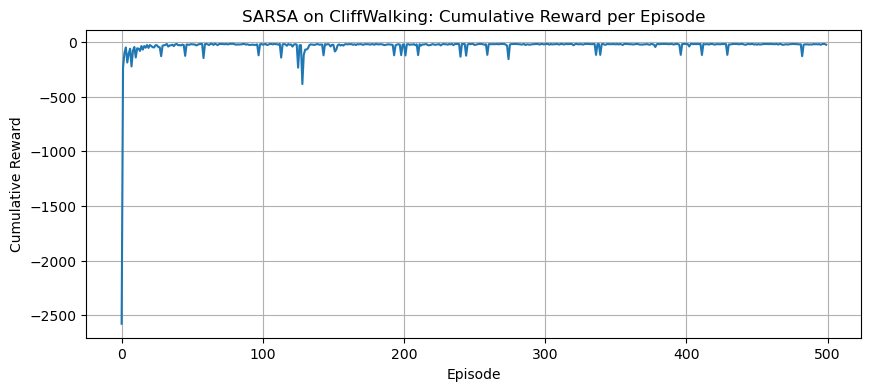

Learned Policy (Arrows):
> > > > > > > > > > > v
^ ^ ^ ^ ^ > > > > ^ > v
^ ^ < ^ ^ ^ ^ ^ ^ ^ ^ v
^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ G

SARSA (CliffWalking) Experiment Analysis
-----------------------------------------------------
• SARSA (on-policy TD control) is implemented with an ε-greedy policy (ε = 0.1).
• To ensure compatibility with the updated Gym API, env.reset() is checked to properly extract the integer state.
• The cumulative reward per episode shows the agent's learning progress over 500 episodes.
• The final learned policy is displayed on a 4x12 grid, with arrows indicating the preferred action for each state
  and 'G' marking the goal state.
• The results illustrate improvement over episodes and convergence towards a policy that minimizes risk (avoids the cliff).


In [9]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


# ----- Set Up Environment and SARSA Parameters -----
env = gym.make('CliffWalking-v0')  # CliffWalking is a 4x12 grid environment.
n_actions = env.action_space.n      # Number of available actions.
n_states = env.observation_space.n  # Total number of states in the grid.

# SARSA hyperparameters
alpha = 0.5       # Learning rate.
gamma = 0.9       # Discount factor.
epsilon = 0.1     # Exploration rate for ε-greedy.
n_episodes = 500  # Number of episodes to train.

# Initialize the Q-table with zeros.
Q = np.zeros((n_states, n_actions))
episode_rewards = []  # Store cumulative reward per episode.

def epsilon_greedy(state):
    """
    Choose an action via ε-greedy policy.
    Input state is assumed to be an integer.
    """
    if np.random.rand() < epsilon:
        return np.random.choice(n_actions)   # Explore using a random action.
    else:
        return np.argmax(Q[state])            # Exploit: choose the best known action.

# ----- SARSA Training Loop -----
for ep in range(n_episodes):
    # Handle the reset() output to obtain a state as an integer.
    result = env.reset()
    if isinstance(result, tuple) and len(result) == 2:
        state, _ = result
    else:
        state = result

    action = epsilon_greedy(state)
    done = False
    total_reward = 0

    while not done:
        result = env.step(action)
        # Handle both new API (5 items) and old API (4 items).
        if len(result) == 5:
            next_state, reward, terminated, truncated, _ = result
            done = terminated or truncated
        else:
            next_state, reward, done, _ = result

        total_reward += reward
        next_action = epsilon_greedy(next_state)

        # SARSA update rule: Q(s,a) ← Q(s,a) + α [r + γ Q(s',a') − Q(s,a)]
        Q[state, action] += alpha * (reward + gamma * Q[next_state, next_action] - Q[state, action])
        state = next_state
        action = next_action

    episode_rewards.append(total_reward)

# ----- Plot Cumulative Reward per Episode -----
plt.figure(figsize=(10, 4))
plt.plot(episode_rewards)
plt.title("SARSA on CliffWalking: Cumulative Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.grid(True)
plt.show()

# ----- Visualize the Learned Policy -----
# Map numeric actions to arrow symbols for clarity.
policy_arrows = np.empty(n_states, dtype=object)
action_dict = {0: '^', 1: '>', 2: 'v', 3: '<'}  # Up, Right, Down, Left.

for state in range(n_states):
    # Typically, the goal state is the bottom-right cell (last state).
    if state == n_states - 1:
        policy_arrows[state] = 'G'
    else:
        best_action = np.argmax(Q[state])
        policy_arrows[state] = action_dict[best_action]

# Reshape the learned policy into a 4x12 grid.
policy_grid = policy_arrows.reshape((4, 12))
print("Learned Policy (Arrows):")
for row in policy_grid:
    print(" ".join(row))

# ----- Experiment Analysis -----
print("\nSARSA (CliffWalking) Experiment Analysis")
print("-----------------------------------------------------")
print("• SARSA (on-policy TD control) is implemented with an ε-greedy policy (ε = 0.1).")
print("• To ensure compatibility with the updated Gym API, env.reset() is checked to properly extract the integer state.")
print("• The cumulative reward per episode shows the agent's learning progress over 500 episodes.")
print("• The final learned policy is displayed on a 4x12 grid, with arrows indicating the preferred action for each state")
print("  and 'G' marking the goal state.")
print("• The results illustrate improvement over episodes and convergence towards a policy that minimizes risk (avoids the cliff).")